1. Dataset Structure Overview
- Inspect folder structure (train and test folders).
- List disease classes.
- Check how many classes exist.

In [2]:
# Step1:Setup and structure check
import os
import glob
import pandas as pd
import numpy as np

# set dataset paths
train_dir = 'E:/CY Tech/Big Data project/Project 2 DermNet Skin Disease Classification/Data/Raw/train'
test_dir = 'E:/CY Tech/Big Data project/Project 2 DermNet Skin Disease Classification/Data/Raw/test'

# basic checks
print("Train dir exists:", os.path.isdir(train_dir))
print("Test dir exists :", os.path.isdir(test_dir))

# list classes from train
train_classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
test_classes  = sorted([d for d in os.listdir(test_dir)  if os.path.isdir(os.path.join(test_dir, d))])

print("\nNumber of classes (train):", len(train_classes))
print("Number of classes (test) :", len(test_classes))

# quick sanity check: same label set in train and test
same_label_set = set(train_classes) == set(test_classes)
print("Train/Test classes match:", same_label_set)

# count images per class in train and test
def count_images(folder):
    rows = []
    for c in sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]):
        pattern = os.path.join(folder, c, '*')
        n_imgs = len([p for p in glob.glob(pattern) if os.path.isfile(p)])
        rows.append((c, n_imgs))
    return pd.DataFrame(rows, columns=['class', 'count'])

train_counts = count_images(train_dir)
test_counts  = count_images(test_dir)

print("\nTrain image counts (head):")
display(train_counts.head())

print("Test image counts (head):")
display(test_counts.head())

print("Total train images:", int(train_counts['count'].sum()))
print("Total test images :", int(test_counts['count'].sum()))

Train dir exists: True
Test dir exists : True

Number of classes (train): 23
Number of classes (test) : 23
Train/Test classes match: True

Train image counts (head):


,class,count
0,Acne and Rosacea Photos,840
1,Actinic Keratosis Basal Cell Carcinoma and oth...,1149
2,Atopic Dermatitis Photos,489
3,Bullous Disease Photos,448
4,Cellulitis Impetigo and other Bacterial Infect...,288


Test image counts (head):


,class,count
0,Acne and Rosacea Photos,312
1,Actinic Keratosis Basal Cell Carcinoma and oth...,288
2,Atopic Dermatitis Photos,123
3,Bullous Disease Photos,113
4,Cellulitis Impetigo and other Bacterial Infect...,73


Total train images: 15557
Total test images : 4002


2. Count Images Per Class

- Count how many images each class has in the train set.
- Identify if there is class imbalance.

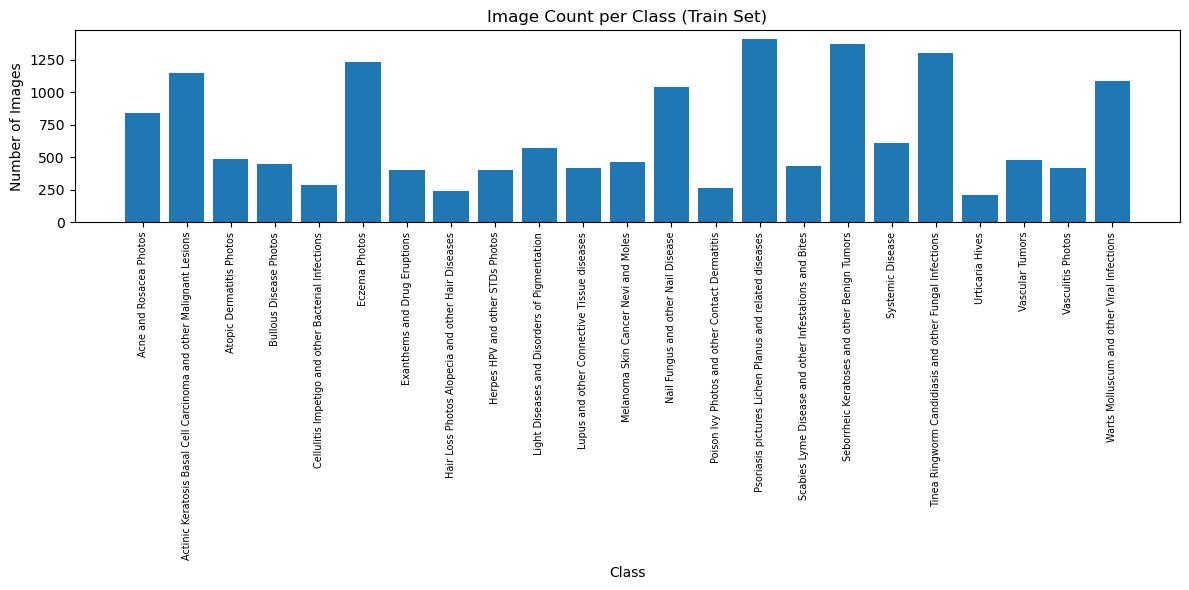

In [3]:
# Step 2: Class distribution in the train set

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(train_counts['class'], train_counts['count'])
plt.xticks(rotation=90, fontsize=7)
plt.title('Image Count per Class (Train Set)')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

3. Sample Image Display

- Select a few random images from different classes.
- Display them to understand quality, size, colors.

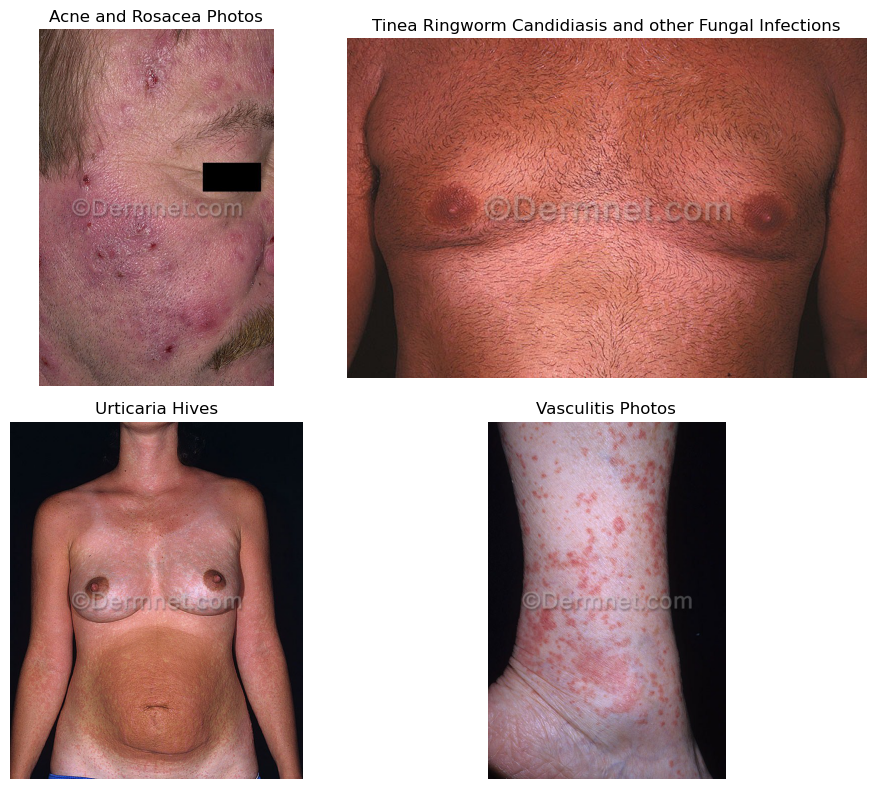

In [4]:
# Step 3 :Display sample images from random classes

import random
import matplotlib.pyplot as plt
from PIL import Image

# pick 4 random classes
sample_classes = random.sample(train_classes, 4)

plt.figure(figsize=(10,8))

for i, cls in enumerate(sample_classes):
    # get all image paths for this class
    class_path = os.path.join(train_dir, cls)
    images = glob.glob(os.path.join(class_path, '*'))

    # pick one random image from the class
    img_path = random.choice(images)
    img = Image.open(img_path)

    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

4. Image Size and Format Decisions

- Decide the target image size for the model.
- Decide on color channels (RGB or grayscale).

Original size: (720, 472)
Image mode : RGB


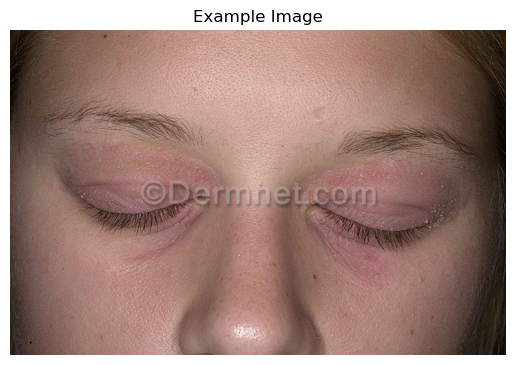

In [5]:
# Step 4: Inspect image size and format

import numpy as np

# pick one image from the train set to inspect
example_class = random.choice(train_classes)
example_path = glob.glob(os.path.join(train_dir, example_class, '*'))[0]

img = Image.open(example_path)
print("Original size:", img.size)  # (width, height)
print("Image mode :", img.mode)    # should be RGB

# show it
plt.imshow(img)
plt.title('Example Image')
plt.axis('off')
plt.show()

5. Train, Validation, Test Strategy

- Use existing train and test folders.
- Create a validation split from the training set.

In [6]:
# Step 5: Set up directory paths and validation split strategy

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# final decisions (we will confirm based on earlier image size)
img_height = 224
img_width = 224

# We will use this generator to split train into train + validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Train subset (80% of train folder)
train_generator_preview = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation subset (20% of train folder)
val_generator_preview = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Test generator (no validation split here)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator_preview = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 12453 images belonging to 23 classes.
Found 3104 images belonging to 23 classes.
Found 4002 images belonging to 23 classes.


6. Preprocessing Plan

- Decide on normalization (rescale)
- Decide on data augmentation (rotation, zoom, flips)
- Plan how to handle class imbalance

In [7]:
# Step 6 : Preprocessing decisions

img_height = 224
img_width = 224
color_mode = 'rgb'
normalization = 'rescale=1./255'
augmentation_plan = ['rotation', 'zoom', 'horizontal_flip', 'shift']
imbalance_strategy = ['data_augmentation', 'class_weights']

print("Image size:", img_height, img_width)
print("Color mode:", color_mode)
print("Normalization:", normalization)
print("Augmentation:", augmentation_plan)
print("Imbalance strategy:", imbalance_strategy)

Image size: 224 224
Color mode: rgb
Normalization: rescale=1./255
Augmentation: ['rotation', 'zoom', 'horizontal_flip', 'shift']
Imbalance strategy: ['data_augmentation', 'class_weights']
